# 2024 Fall CS180 Project 3

In [1]:
''' Here are all the libraries used in this project. '''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.io as skio
import skimage as sk
from scipy.spatial import Delaunay
from skimage.draw import polygon
from IPython.display import Image, display

## Part 1: Defining Correspondences

&emsp;&emsp;For this part, we will deal with the portraits of George and our old friend Derek. I have chosen 79 corresponding points for your convenience. You could also use `labeling_tool.py` to generate you own points if you want!

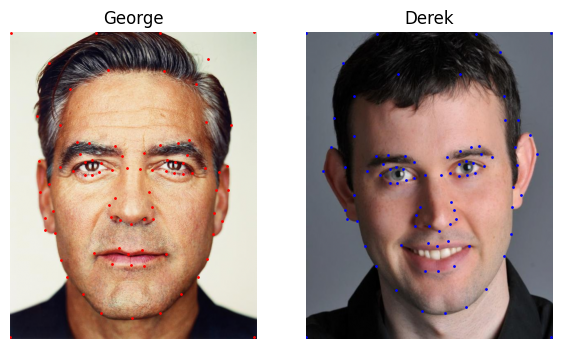

In [2]:
# Load the information of the corresponding points.
im1_points = np.loadtxt('./media/points_george_small.txt')
im2_points = np.loadtxt('./media/points_DerekPicture.txt')

# Load the images.
imname1 = './media/george_small.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)

imname2 = './media/DerekPicture.jpg'
im2 = skio.imread(imname2)
im2 = sk.img_as_float(im2)

im1_x, im1_y = zip(*im1_points)
im2_x, im2_y = zip(*im2_points)

fig, axes = plt.subplots(1, 2, figsize=(7, 5))
axes[0].imshow(im1)
axes[0].plot(im1_x, im1_y, 'ro', markersize=1)
axes[0].set_title('George')
axes[0].axis('off')
axes[1].imshow(im2)
axes[1].plot(im2_x, im2_y, 'bo', markersize=1)
axes[1].set_title('Derek')
axes[1].axis('off')
plt.savefig('./output/points.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;Then compute the Delaunay triangulation at the midway shape.

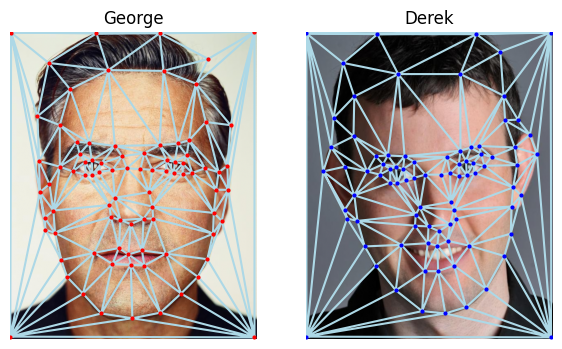

In [3]:
# Plot the triangulation of the chosen points.
def plot_triangulation(im1, points1, im2, points2, triangulation):
    im1_x, im1_y = zip(*points1)
    im2_x, im2_y = zip(*points2)

    fig, axes = plt.subplots(1, 2, figsize=(7, 5))
    axes[0].imshow(im1)
    axes[0].plot(im1_x, im1_y, 'ro', markersize=2)
    axes[0].triplot(points1[:, 0], points1[:, 1], \
                triangulation.simplices, color='#ADD8E6', markersize=1)
    axes[0].set_title('George')
    axes[0].axis('off')
    axes[1].imshow(im2)
    axes[1].plot(im2_x, im2_y, 'bo', markersize=2)
    axes[1].triplot(points2[:, 0], points2[:, 1], \
                triangulation.simplices, color='#ADD8E6', markersize=1)
    axes[1].set_title('Derek')
    axes[1].axis('off')
    plt.savefig('./output/triangulation.jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Compute the Delaunay triangulation at the midway shape.
mid_points = (im1_points + im2_points) / 2
triangulation = Delaunay(mid_points)
plot_triangulation(im1, im1_points, im2, im2_points, triangulation)

## Part 2: Computing the "Mid-way Face"

&emsp;&emsp;Before computing the whole morph sequence, we need to compute the mid-way face. This would involve: 
1. Computing the average shape (a.k.a the average of each keypoint location in the two faces).
2. Warping both faces into that shape.
3. Averaging the colors together.

&emsp;&emsp;The main task in warping the faces into the average shape is implementing an affine warp for each triangle in the triangulation from the original images into this new shape. Instead of looping over the pixels, we iterated through all the triangles pairs. For each triangle in the average shape, we got the affine projection to the corresponding triangles in each image. Then, for each pixel in the triangle, we found the corresponding points in each image and set value to weighted average (cross-dissolve each triangle).

&emsp;&emsp;To create the mid-way face, we warped both faces to the average shape and then blended them using equal weights, i.e. $0.5$. 

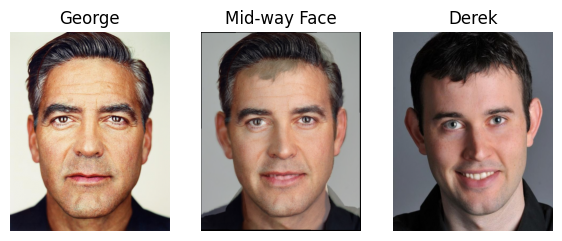

In [4]:
# Compute an affine transformation matrix between two triangles.
def computeAffine(tri1_pts, tri2_pts):
    x1 = np.insert(tri1_pts.T, 2, values=np.ones(3), axis=0)
    x2 = np.insert(tri2_pts.T, 2, values=np.ones(3), axis=0)
    return x2 @ np.linalg.inv(x1)

# Find the corresponding points in each image.
def find_points(tri1_pts, tri2_pts):
    # Get the affine projection to the corresponding triangles in each image.
    A = computeAffine(tri1_pts, tri2_pts)

    # Find the corresponding points in the affine projection.
    points_to = polygon(tri2_pts[:, 0], tri2_pts[:, 1])
    points_from = np.insert(np.array(points_to), 2, values=np.ones(points_to[0].shape), axis=0)
    points_from = tuple(np.array((np.linalg.inv(A) @ points_from)[:2]).astype(int))
    return points_to[::-1], points_from[::-1]

# Create the image of the mid-way face.
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    # Create two images to store the new image.
    img1, img2 = np.zeros(im1.shape), np.zeros(im2.shape)

    # Compute the average shape.
    pts_warp = (1 - warp_frac) * im1_pts + warp_frac * im2_pts

    # For each triangle in the average shape.
    for triangle in tri.simplices:
        tri1, tri2, tri_mid = im1_pts[triangle], im2_pts[triangle], pts_warp[triangle]

        # Find the corresponding points in each image.
        pos_mid1, pos1 = find_points(tri1, tri_mid)
        pos_mid2, pos2 = find_points(tri2, tri_mid)

        # Set value to weighted average (cross-dissolve each triangle)
        img1[pos_mid1] = (1 - dissolve_frac) * im1[pos1]
        img2[pos_mid2] = dissolve_frac * im2[pos2]

    return img1 + img2

midway_face = morph(im1,im2,im1_points,im2_points,triangulation,warp_frac=0.5,dissolve_frac=0.5)
fig, axes = plt.subplots(1, 3, figsize=(7, 5))
axes[0].imshow(im1)
axes[0].set_title('George')
axes[0].axis('off')
axes[1].imshow(midway_face)
axes[1].set_title('Mid-way Face')
axes[1].axis('off')
axes[2].imshow(im2)
axes[2].set_title('Derek')
axes[2].axis('off')
plt.savefig('./output/midway_face.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Part 3: The Morph Sequence

&emsp;&emsp;Then we could generate a video sequence of the morph. I followed the method mentioned in the course.
1. Define corresponding points.
2. Define triangle on points.
   - Use same triangulation for both images.
3. For each  $t = 0 :$ step $: 1$
   - Compute the average shape at $t$ (weighted average of points).
   - For each triangle in the average shape:
      - Get the affine projection to the correponding triangles in each image.
      - For each pixel in the triangle, find the correponding points in each image and set value to weighted average (cross-dissolve each triangle).
   - Save the image as the nect frame of the sequence.

In [5]:
# Set the parameters for the video sequence of the morph.
num_frames = 45
fps = 30
interval = 1000 / fps

# Create and save the video sequence.
fig = plt.figure(frameon=False)
fig.set_size_inches(im1.shape[1] / 100, im1.shape[0] / 100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
frames = []
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(im1, im2, im1_points, im2_points, triangulation, t, t)
    frames.append([ax.imshow(midway_img, animated=True)])
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(im2, im1, im2_points, im1_points, triangulation, t, t)
    frames.append([ax.imshow(midway_img, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=interval, blit=True, repeat_delay=1000)
ani.save('./output/morphing.gif', fps=fps, writer='pillow', dpi=100)
plt.close(fig)
# display(Image(filename='./output/morphing.gif', width=300, height=200))

## Part 4: The "Mean face" of a population

&emsp;&emsp;I analyzed a free data set of Danish faces for this part. There are 40 people in this dataset.

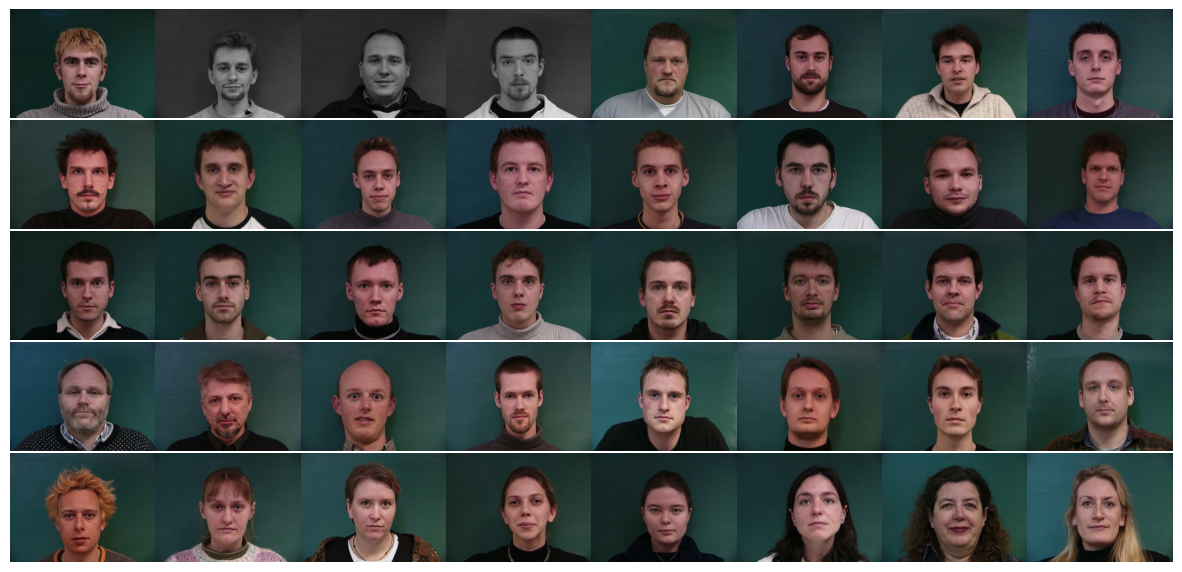

In [6]:
labels_men = ['01-1m', '02-1m', '03-1m', '04-1m', '05-1m', '06-1m', '07-1m', '09-1m', '10-1m',
              '11-1m', '13-1m', '16-1m', '17-1m', '18-1m', '19-1m', '20-1m', '21-1m', '23-1m',
              '24-1m', '25-1m', '26-1m', '27-1m', '28-1m', '29-1m', '31-1m', '32-1m', '33-1m',
              '34-1m', '36-1m', '37-1m', '38-1m', '39-1m', '40-1m']
labels_women = ['08-1f', '12-1f', '14-1f', '15-1f', '22-1f', '30-1f', '35-1f']
labels_Danes = labels_men + labels_women

imgs = []
for label in labels_Danes:
    imname = f'./media/imm_face_db/{label}.jpg'
    im = skio.imread(imname)
    im = sk.img_as_float(im)
    imgs.append(im)

fig, axes = plt.subplots(5, 8, figsize=(15, 7.2))
axes = axes.flatten()
for ax, img in zip(axes, imgs):
    ax.imshow(img)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./output/original.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;We first computed the average face shape of the whole population and two subset of the population, i.e. men and women. This is similar to the morphing process. We find the average shape, the corresponding points and triangulation, then do the warping and cross-dissolving.

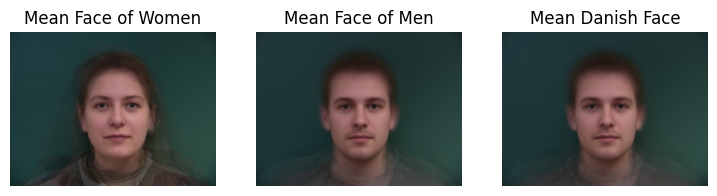

In [7]:
# Extract the information of the correponding points from the asf file.
def extract(asf_file_path, shape):
    coordinates = []
    height, width, _ = shape
    corner_points = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
    with open(asf_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('#') or line.strip() == '':
                continue
            parts = line.split()
            if len(parts) == 7 or len(parts) == 10:
                try:
                    coordinates.append([float(parts[2]) * width, float(parts[3]) * height])
                except ValueError:
                    continue
    # The correponding points in the dataset don't include the corner points.
    # Let me add the manually:)
    coordinates.extend(corner_points)
    return np.array(coordinates)

# Compute the mean face of the given labels.
def meanface(labels, shape):
    # Extract the corresponding points in all the images.
    points = []
    for label in labels:
        points.append(extract(f'./media/imm_face_db/{label}.asf', shape))

    # Compute the mid points and the Delaunay triangulation.
    mid_points = np.mean(points, axis=0)
    triangulation = Delaunay(mid_points)

    # Compute the mean face.
    # P.S. This procedure is just like morph.
    faces = []
    for label in labels:
        imname = f'./media/imm_face_db/{label}.jpg'
        im = skio.imread(imname)
        im = sk.img_as_float(im)
        img = np.zeros(im.shape)
        pts = extract(f'./media/imm_face_db/{label}.asf', im.shape)
        for triangle in triangulation.simplices:
            tri, tri_mid = pts[triangle], mid_points[triangle]
            pos_mid, pos = find_points(tri, tri_mid)
            img[pos_mid] = im[pos]
        faces.append(img)
    return np.mean(faces, axis=0), mid_points

imname = f'./media/imm_face_db/{labels_men[0]}.jpg'
im = skio.imread(imname)
im = sk.img_as_float(im)
meanface_women, _ = meanface(labels_women, im.shape)
meanface_men, _ = meanface(labels_men, im.shape)
meanface_Danes, mean_points = meanface(labels_Danes, im.shape)

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].imshow(meanface_women)
axes[0].set_title('Mean Face of Women')
axes[0].axis('off')
axes[1].imshow(meanface_men)
axes[1].set_title('Mean Face of Men')
axes[1].axis('off')
axes[2].imshow(meanface_Danes)
axes[2].set_title('Mean Danish Face')
axes[2].axis('off')
plt.savefig('./output/meanface.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;Then we could morph each of the faces in the dataset into the average shape. We used the whole population in the dataset for this.

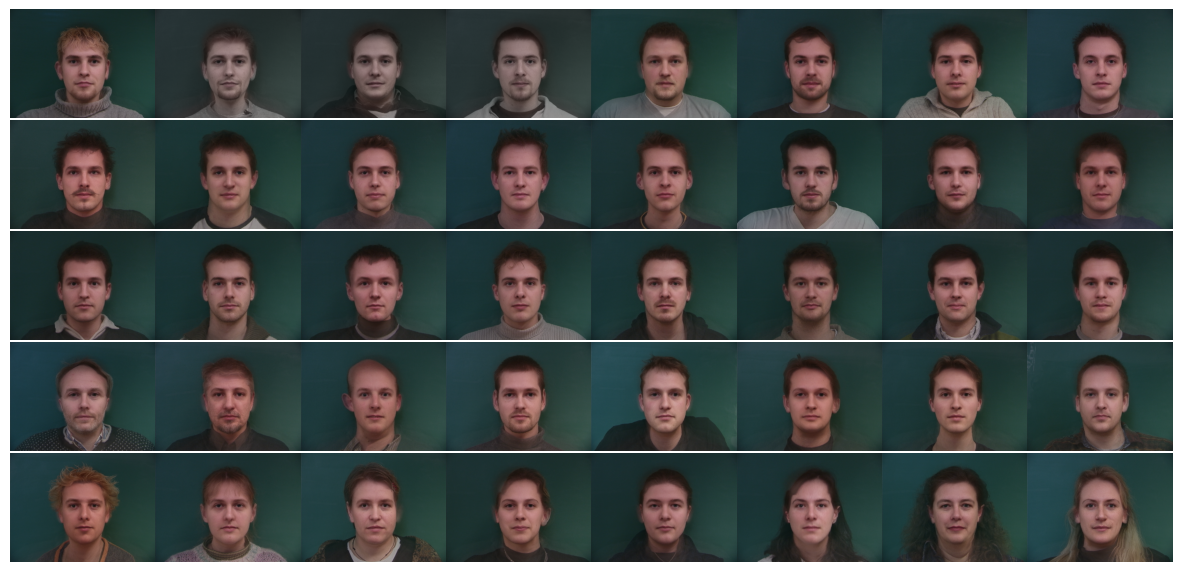

In [8]:
meanfaces = []
for label in labels_Danes:
    imname = f'./media/imm_face_db/{label}.jpg'
    im = skio.imread(imname)
    im = sk.img_as_float(im)
    pts = extract(f'./media/imm_face_db/{label}.asf', im.shape)

    mid_points = (pts + mean_points) / 2
    triangulation = Delaunay(mid_points)

    midway_face = morph(im,meanface_Danes,pts,mean_points,triangulation,warp_frac=1,dissolve_frac=0.5)
    meanfaces.append(midway_face)

fig, axes = plt.subplots(5, 8, figsize=(15, 7.2))
axes = axes.flatten()
for ax, img in zip(axes, meanfaces):
    ax.imshow(img)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./output/meanfaces.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;Warp my portriat into the mean Danish face and the mean Danish face into mine as well. I have provided the corresponding points in`./media/points_portrait.txt`, feel free to use it!

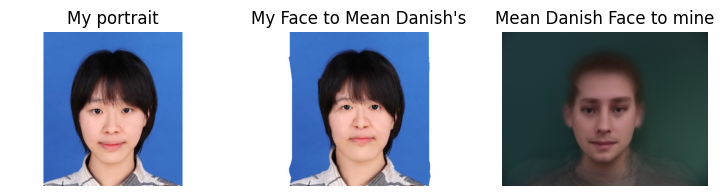

In [9]:
im_points = np.loadtxt('./media/points_portrait.txt')
imname = './media/portrait.jpg'
im = skio.imread(imname)
im = sk.img_as_float(im)

height, width, _ = im.shape
corner_points = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
im_points = np.vstack([im_points, corner_points])

mid_points = (im_points + mean_points) / 2
triangulation = Delaunay(mid_points)

face1 = morph(im,meanface_Danes,im_points,mean_points,triangulation,warp_frac=1,dissolve_frac=0)
face2 = morph(meanface_Danes,im,mean_points,im_points,triangulation,warp_frac=1,dissolve_frac=0)

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].imshow(im)
axes[0].set_title('My portrait')
axes[0].axis('off')
axes[1].imshow(face1)
axes[1].set_title('My Face to Mean Danish\'s')
axes[1].axis('off')
axes[2].imshow(face2)
axes[2].set_title('Mean Danish Face to mine')
axes[2].axis('off')
plt.savefig('./output/meanface_me.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Part 5: Caricatures: Extrapolating from the mean

&emsp;&emsp;I also produced a caricature of my face by extrapolating from the population mean I calculated in the last step, i.e. mean Danish face. This procedure follows:
$$
    \text{caricature} = \text{average face} + \alpha \times (\text{my face} - \text{average face}).
$$

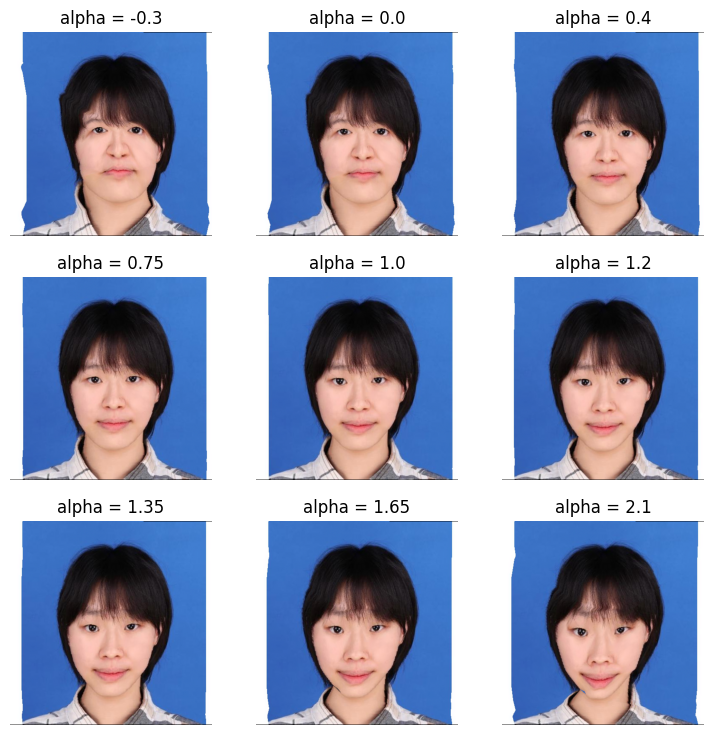

In [10]:
def make_caricature(im1, im2, im1_points, im2_points, alpha):
    # Compute the different part.
    im_diff = im2 + alpha * (im1 - im2)
    pts_diff = im2_points + alpha * (im1_points - im2_points)

    # Add perturbation to avoid singular matrix in morphing.
    np.random.seed(42)
    perturbation = np.random.normal(0, 1e-5, pts_diff.shape)
    pts_diff = pts_diff + perturbation
    triangulation = Delaunay((im1_points + pts_diff) / 2)
    return morph(im1, im_diff, im1_points, pts_diff, triangulation, 1, 0)

caricatures = []
alphas = [-0.3, 0.0, 0.4, 0.75, 1.0, 1.2, 1.35, 1.65, 2.1]
for alpha in alphas:
    caricatures.append(make_caricature(im, meanface_Danes, im_points, mean_points, alpha))
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()
for ax, alpha, img in zip(axes, alphas, caricatures):
    ax.imshow(img[:, 75:550])
    ax.set_title(f'alpha = {alpha}')
    ax.axis('off')
plt.savefig('./output/caricatures.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;It is obvious that the further $\alpha$ deviates from $1.0$, the stranger my face looks. That's because the caricature is the same as my face when $\alpha = 1.0$. You could deduce this from the equation above.

## Bells and Whistles

### Change age/gender/ethnicity/smile of my face.

&emsp;&emsp;I changed my face into a smily Danish man!

In [11]:
labels_smilymen = ['01-2m', '02-2m', '03-2m', '04-2m', '05-2m', '06-2m', '07-2m', 
                   '09-2m', '10-2m', '11-2m', '13-2m', '16-2m', '17-2m', '18-2m', 
                   '19-2m', '20-2m', '21-2m', '23-2m', '24-2m', '25-2m', '26-2m', 
                   '27-2m', '28-2m', '29-2m', '31-2m', '32-2m', '33-2m', '34-2m', 
                   '36-2m', '37-2m', '38-2m', '39-2m', '40-2m'
                   ]
meanface_smilymen, meanpts_smilymen = meanface(labels_smilymen, im.shape)
triangulation = Delaunay((im_points + meanpts_smilymen) / 2)
fig = plt.figure(frameon=False)
fig.set_size_inches(im.shape[1] / 100, im.shape[0] / 100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
frames = []
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(im, meanface_smilymen, im_points, meanpts_smilymen, triangulation, t, t)
    frames.append([ax.imshow(midway_img, animated=True)])
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(meanface_smilymen, im, meanpts_smilymen, im_points, triangulation, t, t)
    frames.append([ax.imshow(midway_img, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=interval, blit=True, repeat_delay=1000)
ani.save('./output/smily.gif', fps=fps, writer='pillow', dpi=100)
plt.close(fig)
# display(Image(filename='./output/smily.gif', width=300, height=200))

&emsp;&emsp;If I just morph the shape:

In [12]:
fig = plt.figure(frameon=False)
fig.set_size_inches(im.shape[1] / 100, im.shape[0] / 100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
frames = []
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(im, meanface_smilymen, im_points, meanpts_smilymen, triangulation, t, 0)
    frames.append([ax.imshow(midway_img, animated=True)])
img_temp = midway_img.copy()
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(img_temp, im, meanpts_smilymen, im_points, triangulation, t, 0)
    frames.append([ax.imshow(midway_img, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=interval, blit=True, repeat_delay=1000)
ani.save('./output/smily_shape.gif', fps=fps, writer='pillow', dpi=100)
plt.close(fig)
# display(Image(filename='./output/smily_shape.gif', width=300, height=200))

&emsp;&emsp;If I just morph the appearance:

In [13]:
fig = plt.figure(frameon=False)
fig.set_size_inches(im.shape[1] / 100, im.shape[0] / 100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
frames = []
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(im, meanface_smilymen, im_points, meanpts_smilymen, triangulation, 0, t)
    frames.append([ax.imshow(midway_img, animated=True)])
img_temp = midway_img.copy()
for t in np.linspace(0, 1, num_frames):
    midway_img = morph(img_temp, im, im_points, im_points, triangulation, 0, t)
    frames.append([ax.imshow(midway_img, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=interval, blit=True, repeat_delay=1000)
ani.save('./output/smily_appearance.gif', fps=fps, writer='pillow', dpi=100)
plt.close(fig)
# display(Image(filename='./output/smily_appearance.gif', width=300, height=200))

### Make a morphing music video on a theme.

&emsp;&emsp;I made a morphing music video of the main characters in *EVANGELION*. Here I provide a gif version for you, you could find the mp4 version with music <a href="https://youtube.com/shorts/_50UpfsuSso" target="_blank">Here!</a> (Please click on the link to view the video)

In [14]:
names = ['katsuragi', 'zenkaiten', 'jackpot', 'yokoku', 
         'aquarium', 'asuka', 'mari', 'kaworu', 'rei', 'shinji'
         ]
frames = []
shape = (500, 550, 3)
height, width, _ = shape
corner_points = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
fig = plt.figure(frameon=False)
fig.set_size_inches(shape[1] / 100, shape[0] / 100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
imname1 = f'./media/eva/{names[0]}.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)
for _ in range(5):
    frames.append([ax.imshow(im1, animated=True)])
for i in range(9):
    im1_points = np.loadtxt(f'./media/eva/points_{names[i]}.txt')
    im2_points = np.loadtxt(f'./media/eva/points_{names[i + 1]}.txt')

    imname1 = f'./media/eva/{names[i]}.jpg'
    im1 = skio.imread(imname1)
    im1 = sk.img_as_float(im1)

    imname2 = f'./media/eva/{names[i + 1]}.jpg'
    im2 = skio.imread(imname2)
    im2 = sk.img_as_float(im2)

    im1_points = np.vstack([im1_points, corner_points])
    im2_points = np.vstack([im2_points, corner_points])

    mid_points = (im1_points + im2_points) / 2
    triangulation = Delaunay(mid_points)

    for t in np.linspace(0, 1, num_frames):
        midway_img = morph(im1, im2, im1_points, im2_points, triangulation, t, t)
        frames.append([ax.imshow(midway_img, animated=True)])
    for _ in range(5):
        frames.append([ax.imshow(im2, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=interval, blit=True, repeat_delay=1000)
ani.save('./output/eva.gif', fps=fps, writer='pillow', dpi=100)
plt.close(fig)
# display(Image(filename='./output/eva.gif', width=300, height=200))